#  Lab: The Zen of Logistic Regression Multivariate Normal Models and the Posterior Predictive

##### Keywords: bayesian, conjugate prior, gaussian, multivariate normal, logistic regression, classification, posterior predictive, likelihood

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Introduction

Welcome!  This lab will be generally focused on three major topics:  Logistic Regression, Multivariate Normal and the Normal Model, and the Posterior Predictive in the Bayesian workflow.  

Some material from the first part of the notebook covering Logistic regression will borrow from [this notebook](https://gist.github.com/vietjtnguyen/6655020) which was derived from the [Caltech "Learning from Data" course](http://work.caltech.edu/telecourse.html), specifically [Lecture 9](http://www.youtube.com/watch?v=qSTHZvN8hzs&hd=1) on the logistic regression model.

Some material from part two of the notebook covering the Normal Conjugate Prior Models will have been influenced by [a lecture from Michael Jordan's Course on Bayesian Inference](https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf) on the same topic as well as from Kevin Murphy's book.

## Logistic Regression

What is Logistic Regression and why would we be interested in it?  A good (if verbose) place to start as is often the case is with the [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression) definition of Logistic Regression:

> In statistics, the logistic model (or logit model) is a widely used statistical model that, in its basic form, uses a logistic function to model a binary dependent variable; many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model; it is a form of binomial regression. Mathematically, a binary logistic model has a dependent variable with two possible values, such as pass/fail, win/lose, alive/dead or healthy/sick; these are represented by an indicator variable, where the two values are labeled "0" and "1". In the logistic model, the log-odds (the logarithm of the odds) for the value labeled "1" is a linear combination of one or more independent variables ("predictors"); the independent variables can each be a binary variable (two classes, coded by an indicator variable) or a continuous variable (any real value). The corresponding probability of the value labeled "1" can vary between 0 (certainly the value "0") and 1 (certainly the value "1"), hence the labeling; the function that converts log-odds to probability is the logistic function, hence the name. The unit of measurement for the log-odds scale is called a logit, from logistic unit, hence the alternative names. Analogous models with a different sigmoid function instead of the logistic function can also be used, such as the probit model; the defining characteristic of the logistic model is that increasing one of the independent variables multiplicatively scales the odds of the given outcome at a constant rate, with each dependent variable having its own parameter; for a binary independent variable this generalizes the odds ratio.

### Introducing Binary Classification

Again we look to Wikipedia for a definition.

> Binary or binomial classification is the task of classifying the elements of a given set into two groups (predicting which group each one belongs to) on the basis of a classification rule. Contexts requiring a decision as to whether or not an item has some qualitative property, some specified characteristic, or some typical binary classification include:
>
> * Medical testing to determine if a patient has certain disease or not – the classification property is the presence of the disease.
> * A "pass or fail" test method or quality control in factories, i.e. deciding if a specification has or has not been met – a Go/no go classification.v
> * Information retrieval, namely deciding whether a page or an article should be in the result set of a search or not – the classification property is the relevance of the article, or the usefulness to the user.

What does this mean for the mathematical task of classification?

The idea behind our classification problem is that we're given a data set $\mathcal{D}$ that is composed  composed of $N$ samples. Each sample is a tuple containing a feature vector and a label. For any sample $n$ the feature vector is a $d+1$ dimensional column vector denoted by ${\bf x}_n$ with $d$ real-valued components known as features. Samples are represented in homogeneous form with the first component equal to $1$: $x_0=1$. Vectors are bold-faced. The associated label is denoted $y_n$ and can take on only two values: $1$ or $0$.

$$
\mathcal{D} = \lbrace ({\bf x}_1, y_1), ({\bf x}_2, y_2), ..., ({\bf x}_N, y_N) \rbrace \\
{\bf x}_n = \begin{bmatrix} 1 & x_1 & ... & x_d \end{bmatrix}^T 
$$

So we have a sample of data points each of which has its own feature vector and label $1$ or $0$.  Classification involves constructing a model that will let us know how to label a particular sample based on its feature values. 

## Some Generated Data

In [2]:
num_observations = 200

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

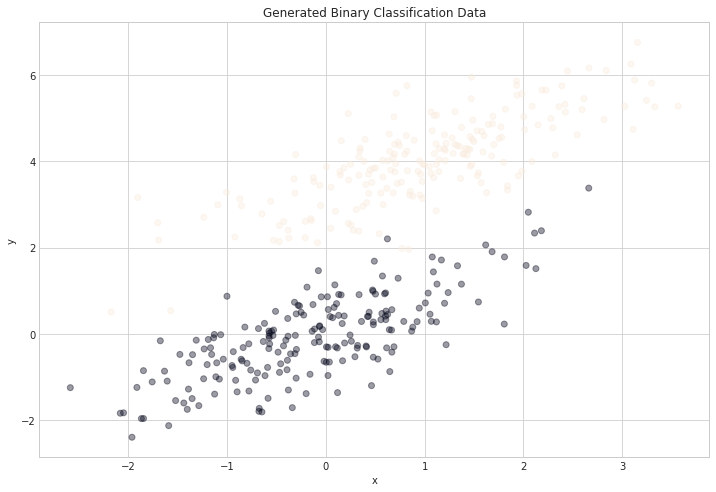

In [3]:
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)
plt.title("Generated Binary Classification Data")
plt.xlabel("x")
plt.ylabel("y");

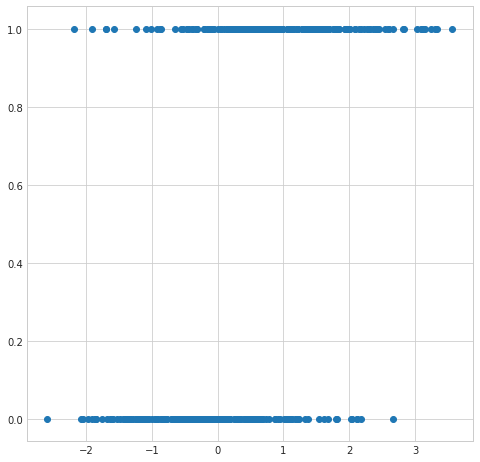

In [4]:
plt.figure(figsize=(8,8))
plt.scatter(simulated_separableish_features[:,0], simulated_labels);

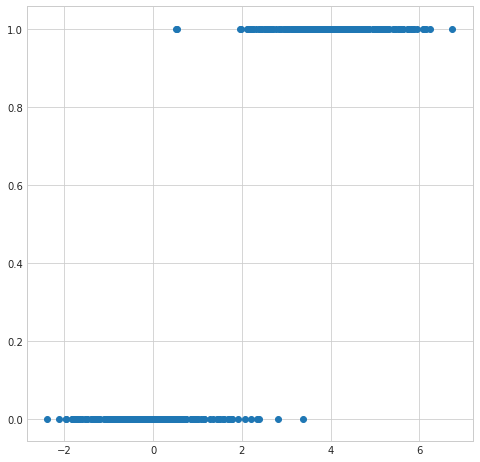

In [5]:
plt.figure(figsize=(8,8))
plt.scatter(simulated_separableish_features[:,1], simulated_labels);

## Linear Regression

![](https://christophm.github.io/interpretable-ml-book/images/linear-class-threshold-1.png "The Problem with Linear Regression for Binary Classification")

* The first problem is that the output from an OLS linear regression model isn't intrinsically meaningful for the classifcation problem.  We'd expect given the input of a partiucular set of feature values an output of something like a probability of a particular classification or maybe even a specific classification.  The output from a OLS linear regression model is just a number on the real line.

* If we tried to interpret the output as a probability then we open ourselves up to dealing with untenable values (below 0 and above 1). 

* Since the model output isn't a probability but nstead some predicted linear interpolation between points it isn't possible to robustly threshold the output in order to distinguish one class from the other (see the picture above).

### Setting Up Logistic Regression

**A Probability Formulation**

So we'd like an interpretation where we can interpret the output of our model as probabilities.  i.e.

The probability that the output is 1 given its input feature values could be represented as:

$$P(y=1 \mid x)$$

If the data samples have $n$ features, and we think we can represent this probability as some function of a linear combination of features which we could represent as:

$$P(y=1 \mid x) =  h_1\left(w_0 + w_1 x_1 + \;...\; + w_d x_d\right) = h_1\left(\sum_{i=0}^d w_i x_i\right) = h_1\left({\bf w} \cdot {\bf x}\right) = h_1\left({\bf w}^T {\bf x}\right)$$

Similarly we could represent the probability that the output is 0 given the input feature values

$$P(y=0 \mid x) =  h_0\left(w_0 + w_1 x_1 + \;...\; + w_d x_d\right) = h_0\left(\sum_{i=0}^d w_i x_i\right) = h_0\left({\bf w} \cdot {\bf x}\right) = h_0\left({\bf w}^T {\bf x}\right)$$

As we only have two classes, by the laws of probability $P(y=1 \mid x)$ = 1 - $P(y=0 \mid x)$.  This implies that $h_1\left({\bf w} \cdot {\bf x}\right) = 1 - h_1\left({\bf w} \cdot {\bf x}\right) $ and we can represent our equations with just the function $h$.

$$\begin{eqnarray}
P(y=1 \mid \v{x}) &=& h(\v{w}\cdot\v{x}) \\
P(y=0 \mid \v{x}) &=& 1 - h(\v{w}\cdot\v{x}).
\end{eqnarray}$$

The model that we choose would need to fit the weights to the data but we need come up with a way to map an arbitrary linear combination of inputs, each potentially ranging in value from $-\infty$ to $\infty$ to an output value in the range of $0$ to $1$.

**Starting with the Odds Ratio**

We'll formulate a potential map by going in the reverse direction.  We'll try to motivate a function that maps from a probability value $p$ with $0\leq p \leq 1$ to a range from $-\infty$ to $\infty$.

We can start by considering the odds ratio, a concept related to probability that can help us. It is equal to the probability of success divided by the probability of failure, and may be familiar to anyone who's ever looked at betting lines in sports matchups:

$$odds(p) = \frac{p}{1-p}$$

Considering the phrase "the odds of the output being 1 given an input" seems to indicate that we've taken a step in the right direction. If we plot the odds function from 0 to 1, there's still a problem

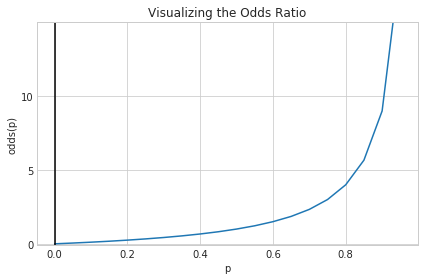

In [6]:
def odds(p):
    return p / (1 - p)

x = np.arange(0, 1, 0.05)
odds_x = odds(x)

plt.plot(x, odds_x)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 15)
plt.xlabel('p')
plt.ylabel('odds(p)')
plt.title('Visualizing the Odds Ratio')

# y axis ticks and gridline
plt.yticks([0.0, 5, 10])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

**Moving on to the Log Odds**

The problem is that our function only maps our probability value $p$ with $0\leq p \leq 1$ to a range from $0$ to $\infty$.  We're actually interested in mapping $p$ to a range from $-\infty$ to $\infty$. The function $log$ though takes a variable with a domain in the positive real numbers and maps it to a range $-\infty$ to $\infty$.  So presumably if we take the log of the odds ratio of p also known as logit(p), we'll have a function that maps from a probability value $p$ with $0\leq p \leq 1$ to a range from $-\infty$ to $\infty$ which was our wish all along.

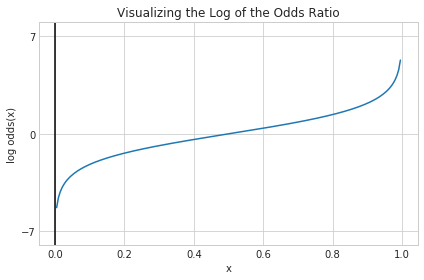

In [7]:
def log_odds(p):
    return np.log(p / (1 - p))

x = np.arange(0.005, 1, 0.005)
log_odds_x = log_odds(x)

plt.plot(x, log_odds_x)
plt.axvline(0.0, color='k')
plt.ylim(-8, 8)
plt.xlabel('x')
plt.ylabel('log odds(x)')
plt.title('Visualizing the Log of the Odds Ratio')


# y axis ticks and gridline
plt.yticks([-7, 0, 7])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

### Logistic Regression Framework

Since in our model we have a function $h$ taking the linear combination of features $(\bf{w}\cdot\bf{x})$ and mapping them to a probability, the function need is actually the inverse of the logit we described in the last section.  Fortunately our link function the **inverse logit** otherwise known as the **logit** and **sigmoid** can be derived from the logit/log odds with every simple math:

$$h(z) = \frac{1}{1 + e^{-z}}.$$

Notice that at $z=0$ this function has the value 0.5. If $z > 0$, $h > 0.5$ and as $z \to \infty$, $h \to 1$. If $z < 0$, $h < 0.5$ and as $z \to -\infty$, $h \to 0$. As long as we identify any value of $y > 0.5$ as 1, and any $y < 0.5$ as 0, we can achieve what we wished above.

This function is plotted below:

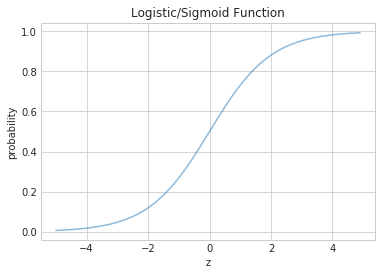

In [8]:
h = lambda z: 1./(1+np.exp(-z))
zs=np.arange(-5,5,0.1)

plt.title("Logistic/Sigmoid Function")
plt.xlabel("z")
plt.ylabel("probability")
plt.plot(zs, h(zs), alpha=0.5);

### Deriving the MLE


The conditional probabilities of $y=1$ or $y=0$ given a particular sample's features $\v{x}$ are:

$$\begin{eqnarray}
P(y=1 | \v{x}) &=& h(\v{w}\cdot\v{x}) \\
P(y=0 | \v{x}) &=& 1 - h(\v{w}\cdot\v{x}).
\end{eqnarray}$$

These two can be written together as

$$P(y|\v{x}, \v{w}) = h(\v{w}\cdot\v{x})^y \left(1 - h(\v{w}\cdot\v{x}) \right)^{(1-y)} $$

Then multiplying over the samples we get the probability of the training $y$ given $\v{w}$ and the $\v{x}$:

$$P(y|\v{x},\v{w}) = P(\{y_i\} | \{\v{x}_i\}, \v{w}) = \prod_{y_i \in \cal{D}} P(y_i|\v{x_i}, \v{w}) = \prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}$$

Why use probabilities? Earlier, we talked about how the regression function $f(x)$ never gives us the $y$ exactly, because of noise. This hold for classification too. Even with identical features, a different sample may be classified differently. 

We said that another way to think about a noisy $y$ is to imagine that our data $\dat$ was generated from  a joint probability distribution $P(x,y)$. Thus we need to model $y$ at a given $x$, written as $P(y \mid x)$, and since $P(x)$ is also a probability distribution, we have:

$$P(x,y) = P(y \mid x) P(x) ,$$

and can obtain our joint probability ($P(x, y))$.

Indeed its important to realize that a particular sample can be thought of as a draw from some "true" probability distribution. If for example the probability of classifying a sample point as a '0' was 0.1, and it turns out that the sample point was actually a '0', it does not mean that this model was necessarily wrong. After all, in roughly a 10th of the draws, this new sample would be classified as a '0'! But, of-course its more unlikely than its likely, and having good probabilities means that we'll be likely right most of the time, which is what we want to achieve in classification. 

Thus its desirable to have probabilistic, or at the very least, ranked models of classification where you can tell which sample is more likely to be classified as a '1'. 



Now if we maximize $$P(y \mid \v{x},\v{w})$$ we will maximize the chance that each point is classified correctly, which is what we want to do. This is a principled way of obtaining the highest probability classification. This **maximum likelihood** estimation maximises the **likelihood of the sample y**, 

$$\like = P(y \mid \v{x},\v{w}).$$ 


Again, we can equivalently maximize 

$$\loglike = log(P(y \mid \v{x},\v{w}))$$ 

since the natural logarithm $log$ is a monotonic function. This is known as maximizing the **log-likelihood**.


$$\loglike = log \like = log(P(y \mid \v{x},\v{w})).$$


Thus

$$\begin{eqnarray}
\loglike &=& log\left(\prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\
                  &=& \sum_{y_i \in \cal{D}} log\left(h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\                  
                  &=& \sum_{y_i \in \cal{D}} log\,h(\v{w}\cdot\v{x_i})^{y_i} + log\,\left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\\
                  &=& \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x_i})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x_i})) \right )
\end{eqnarray}$$

The negative of this log likelihood (henceforth abbreviated NLL), is also called the cross-entropy, for reasons that will become clearer soon.

$$ NLL = - \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x_i})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x_i})) \right )$$

Substituting in our definition of h we have:

$$ NLL = - \sum_{y_i \in \cal{D}} \left ( y_i log(\frac{1}{1 + e^{-(\v{w}\cdot\v{x_i})}}) + ( 1 - y_i) log(1 - \frac{1}{1 + e^{-(\v{w}\cdot\v{x_i})}}) \right )$$
$$ NLL = - \sum_{y_i \in \cal{D}} \left (- y_i log(1 + e^{-(\v{w}\cdot\v{x_i})}) + ( 1 - y_i) log(\frac{e^{-(\v{w}\cdot\v{x_i})}}{1 + e^{-(\v{w}\cdot\v{x_i})}}) \right )$$
$$ NLL = - \sum_{y_i \in \cal{D}} \left (- y_i log(1 + e^{-(\v{w}\cdot\v{x_i})}) + ( y_i - 1) \left[ \v{w}\cdot\v{x_i} + log(1 + e^{-(\v{w}\cdot\v{x_i})}) \right] \right )$$
$$ NLL = - \sum_{y_i \in \cal{D}} \left (( y_i - 1) (\v{w}\cdot\v{x_i}) - log(1 + e^{-(\v{w}\cdot\v{x_i})}) \right )$$

### Solving LR MLE

* Not Analytically Feasible

* Newton-Raphson/Iterated Reweighted Least Squared

* STOCHASTIC GRADIENT DESCENT

### LR The Bayesian Way 

We constructed earlier the likelihood -- and thus derived formulations for $P(y|\v{x}, \v{w})$.  As is normal in the "Bayesian Workflow" we're not looking for a point estimate for our parameters $\v{w}$, we're looking for the posterior distribution of these parameters given the data.  We only have to choose priors and we can approach the problem in a bayesian way.

**Our likelihood:**

$$P(y|\v{x}, \v{w}) = $$P(\v{w}|\v{x}, \v{y}) \propto P(y|\v{x}, \v{w}) \cdot P(\v{w_j})$$$$

**Our priors:**

We generally choose weakly informative Gaussians for priors:
$$P(\v{w}) = N(\mu,\sigma)  $$

**Our posterior:**
$$P(\v{w}|\v{x}, \v{y}) \propto P(y|\v{x}, \v{w}) \cdot P(\v{w_j})$$
$$P(\v{w}|\v{x}, \v{y}) \propto h(\v{w}\cdot\v{x})^y \left(1 - h(\v{w}\cdot\v{x}) \right)^{(1-y)} \cdot N(\mu,\sigma))$$

Our posterior is very unlikely to be an analytically tractable distribution.  In the future we'll use MCMC methods to generate samples, but for now those means are unavailable.  Even then we have a couple of options:

* Rejection Sampling

* The Laplace Approximation

Once we have the posterior we can do normal bayesian things like generate HDPs, generate point estimates, construct the posterior predictive, etc.


## The Normal-Normal Model

 A random variable $Y$ is normally distributed with mean $\mu$ and variance $\sigma^2$. Thus its density is given by :
 
 $$ p(y \vert \mu, \sigma^2) =  \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{-( \frac{y-\mu}{2 \sigma})^2} $$
 
 
Suppose our model is $\{y_1, \ldots, y_n \vert \mu, \sigma^2 \} \sim N(\mu, \sigma^2)$ then
the likelihood is 

$$
p(y_1, \ldots, y_n \vert \mu, \sigma^2) = 
\prod_{i=1}^{n} p(y_i \vert \mu, \sigma^2)=\prod_{i=1}^{n}  \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{-( \frac{(y_i-\mu)^2}{2\sigma^2})} = 
\frac{1}{ \sqrt{ 2 \pi \sigma^2}}   \exp \left\{  - \frac{1}{2}  \sum_i \frac{(y_i-\mu)^2}{\sigma^2} \right\} 
$$

The conjugate prior for a normal is also a normal which we can write as $$N(\mu | \mu_0, \sigma_0) = \frac{1}{ \sqrt{ 2 \pi \sigma_0^2}} \exp \left\{-\frac{(\mu-\mu_0)^2}{\sigma_0^2} \right\} $$

We can now write the posterior for this model thus:

$$ p( \mu, \sigma^2 \vert  y_1, \ldots, y_n, \sigma^2)  \propto \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{ - \frac{1}{2\sigma^2} \sum (y_i - \mu)^2 } \, p(\mu, \sigma^2)$$

Lets see the posterior of $\mu$ assuming we 
know $\sigma^2$.  

## Normal Model for fixed $\sigma$

Now we wish to condition on a known $\sigma^2$. The prior probability distribution for it can then be written as:

$$p(\sigma^2) = \delta(\sigma^2 -\sigma_0^2)$$

(which does integrate to 1).

Now, keeping in mind that $p(\mu, \sigma^2) = p(\mu \vert \sigma^2) p(\sigma^2)$ and carrying out the integral over $\sigma^2$ which because of the delta distribution means that we must just substitute $\sigma_0^2$ in, we get:

$$ p( \mu \vert  y_1, \ldots, y_n, \sigma^2 = \sigma_0^2)  \propto p(\mu \vert \sigma^2=\sigma_0^2) \,e^{ - \frac{1}{2\sigma_0^2} \sum (y_i - \mu)^2 }$$

where I have dropped the $\frac{1}{\sqrt{2\pi\sigma_0^2}}$ factor as there is no stochasticity in it (its fixed).


Say we have the prior

$$ p(\mu \vert \sigma^2) = \exp \left\{ -\frac{1}{2 \tau^2} (\hat{\mu}-\mu)^2 \right\} $$

then it can be shown that the posterior is 

$$  p( \mu \vert  y_1, \ldots, y_n, \sigma^2) \propto \exp \left\{ -\frac{a}{2} (\mu-b/a)^2 \right\} $$
where 
$$ a = \frac{1}{\tau^2} + \frac{n}{\sigma_0^2} , \;\;\;\;\; b = \frac{\hat{\mu}}{\tau^2} + \frac{\sum y_i}{\sigma_0^2} $$
This is a normal density curve with $1/\sqrt{a}$ playing the role of the 
standard deviation and $b/a$ playing the role of the mean. Re-writing this, 

$$ p( \mu \vert  y_1, \ldots, y_n, \sigma^2)  \propto \exp\left\{ -\frac{1}{2} \left( \frac{\mu-b/a}{1/\sqrt(a)}\right)^2 \right\} $$

**The conjugate of the normal is the normal itself**. 

Define $\kappa = \sigma^2 / \tau^2 $ to be the variance of the sample model  in units of variance
of our prior belief (prior distribution) then the *posterior mean* is 

$$\mu_p = \frac{b}{a} = \frac{ \kappa}{\kappa + n }  \hat{\mu} + \frac{n}{\kappa + n} \bar{y} $$

which is a weighted average of prior mean and sampling mean.
The variance is 

$$ \sigma_p^2 = \frac{1}{1/\tau^2+n/\sigma^2} $$
or better 

$$ \frac{1}{\sigma_p^2} = \frac{1}{\tau^2} + \frac{n}{\sigma^2}. $$

You can see that as $n$ increases, the data dominates the prior and the posterior mean approaches the data mean, with the posterior distribution narrowing...

## Example of the normal model for fixed $\sigma$

We have data on the wing length in millimeters of a nine members of a particular species of moth. We wish to make inferences from those measurements on the population mean $\mu$. Other studies show the wing length to be around 19 mm. We also know that the length must be positive. We can choose a prior that is normal and most of the density is above zero ($\mu=19.5,\tau=10$). This is only a **marginally informative** prior.

Many bayesians would prefer you choose relatively uninformative (and thus weakly regularizing) priors. This keeps the posterior in-line (it really does help a sampler remain in important regions), but does not add too much information into the problem.

The measurements were: 16.4, 17.0, 17.2, 17.4, 18.2, 18.2, 18.2, 19.9, 20.8 giving $\bar{y}=18.14$. 

In [9]:
Y = [16.4, 17.0, 17.2, 17.4, 18.2, 18.2, 18.2, 19.9, 20.8]
#Data Quantities
sig = np.std(Y) # assume that is the value of KNOWN sigma (in the likelihood)
mu_data = np.mean(Y)
n = len(Y)
print("sigma", sig, "mu", mu_data, "n", n)

sigma 1.3309237486390264 mu 18.144444444444446 n 9


In [10]:
# Prior mean
mu_prior = 19.5
# prior std
tau = 10 

In [11]:
kappa = sig**2 / tau**2
sig_post =np.sqrt(1./( 1./tau**2 + n/sig**2));
# posterior mean
mu_post = kappa / (kappa + n) *mu_prior + n/(kappa+n)* mu_data
print("mu post", mu_post, "sig_post", sig_post)

mu post 18.147107175068875 sig_post 0.4432053110061127


In [12]:
#samples
N = 15000
theta_prior = np.random.normal(loc=mu_prior, scale=tau, size=N);
theta_post = np.random.normal(loc=mu_post, scale=sig_post, size=N);

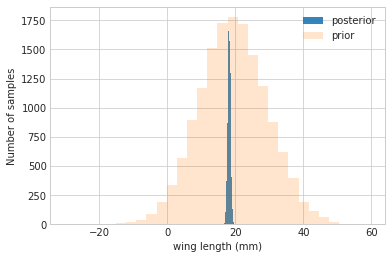

In [13]:
plt.hist(theta_post, bins=30, alpha=0.9, label="posterior");
plt.hist(theta_prior, bins=30, alpha=0.2, label="prior");
#plt.xlim([10, 30])
plt.xlabel("wing length (mm)")
plt.ylabel("Number of samples")
plt.legend();

In the case that we dont know $\sigma^2$ or wont estimate it the way we did above, it turns out that a conjugate prior for the precision (inverse variance) is a gamma distribution. Interested folks can see Murphy's detailed document [here](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf). but you can always just use our MH machinery to draw from any vaguely informative prior for the variance ( a gamma for the precision or even for the  variance).

## Posterior Predictive Trick

* Sample From the Posterior

* Use posterior samples to sample from the Likelihood